In [30]:
import os
from tqdm import tqdm
import PyPDF2
import pandas as pd
import re
import shutil

import matplotlib.pyplot as plt

In [31]:


PDF_FILE_DIR='./extract_pdf'

def parse_by_PyPDF2(pdf_path):
    mypdf = open(pdf_path, mode='rb')

    pdf_document = PyPDF2.PdfFileReader(mypdf)

    page_num = pdf_document.numPages
    page_txts = []

    try:
        annots = pdf_document.getPage(0).getObject()['/Annots'][0]
        page_url = annots.getObject()['/A']['/URI']
    except:
        page_url = None

    for page in range(page_num):
        txt = pdf_document.getPage(page).extractText()
        page_txts.append(txt)

    return page_txts, page_url


PDF_PAGES={}
for fname in tqdm(os.listdir(PDF_FILE_DIR),desc='pdf converting'):
    if not fname.endswith('.pdf'):
        continue
    fp=os.path.join(PDF_FILE_DIR,fname)
    page_txts,page_url=parse_by_PyPDF2(fp)
    PDF_PAGES[fname]=(page_txts,page_url)

pdf文件解析中: 100%|█████████████████████████████████████████████████████████████████| 502/502 [00:57<00:00,  8.72it/s]


In [32]:
p_title=re.compile('\d{4}.*?\d{4,5}',re.IGNORECASE|re.S)
p_date=re.compile('[a-z]+\.* \d{1,2},* \d{4}',re.IGNORECASE|re.S)
p_citation=re.compile('Reporter\n(.*?)\n',re.IGNORECASE|re.S)

p_matterSMP=re.compile('\nMATTER OF \w-\w-\w-\n',re.IGNORECASE|re.S)
# p_appeal_motion=re.compile('Reporter\n(.*?)\n',re.IGNORECASE|re.S)
p_number_aao=re.compile('ID#\s+(\d+)\s+\((AAO.*?)\)',re.IGNORECASE|re.S)
p_status=re.compile('ORDER\s*:(.*?)\.',re.IGNORECASE|re.S)
p_counsel=re.compile('Counsel.*?ON BEHALF OF (APPLICANT|RESPONDENT):\s+([\S ]+)\n',re.IGNORECASE|re.S)
p_motion=re.compile('\Wmotion\W',re.IGNORECASE|re.S)

summary_begin=['The Applicant,* a native and citizen',
               'The applicant seeks',
               'The applicant is',
               'The Applicant, an',
               'The Applicant, who',
               'The respondent',
               'the petitioner',
               'The Obligor',
               ]
p_summary=re.compile(f"({'|'.join(summary_begin)}).*?(\.\n|$)",re.IGNORECASE|re.S)

core_terms_end=[
    'opinion',
    'headnotes',
    '\[',
    'counsel',
]
p_core_terms=re.compile(f"Core Terms(.*?)({'|'.join(core_terms_end)})",re.IGNORECASE|re.S)


BASE_DICT = {
    'title': None,
    'date': None,
    'appealOrMotion':None,
    'core_terms':None,
    'citation': None,
    'S-M-P':None,
    'number': None,
    'aao': None,
    'counsel': None,
    'status': None,
    'summary': None,
}

def extract_info(pages):

    page_first=pages[0]
    page_last=pages[-1]

    title=p_title.search(page_first).group().split('\n')[0]
    date=p_date.search(page_first).group()
    citation=p_citation.search(page_first).group(1)


    # core terms
    if p_core_terms.search(pages[0]):
        core_terms=p_core_terms.search(pages[0]).group(1)
        core_terms=core_terms.replace('\n','')
    else:
        core_terms=None

    SMP_FLAG= True if p_matterSMP.search(page_first) else False
    if SMP_FLAG:
        if p_number_aao.search(page_last):
            number,aao=p_number_aao.search(page_last).groups()
        elif p_number_aao.search(pages[-2]):
            number,aao=p_number_aao.search(pages[-2]).groups()
        else:
            number,aao=None,'UNKNOWN'    
    else:
        number,aao=None,'UNKNOWN'

    COUNSEL_FLAG=p_counsel.search(page_first)
    if COUNSEL_FLAG:
        counsel=COUNSEL_FLAG.group()
        if 'REPRESENTATIVE' in counsel.upper():
            counsel='not represented'
        elif 'redacted' in counsel.lower():
            counsel='represented' 
        # 9020 special case
        elif 'RESPONDENT' in counsel.upper():
            counsel='represented' 
    else:
        counsel='UNKNOWN'


    if p_status.search(page_last):
        status=p_status.search(page_last).group(1).strip()
    elif p_status.search(pages[-2]):
        status=p_status.search(pages[-2]).group(1).strip()
    else:
        status=None

    A_or_M=None
    if status:
        if 'motion' in status:
            A_or_M='motion'
        elif 'appeal' in status:
            A_or_M='appeal'
    if A_or_M is None:
        if p_motion.search(page_first):
            A_or_M='motion'
        else:
            A_or_M='appeal'
    
    
    if p_summary.search(page_first):
        summary=p_summary.search(page_first).group()
    elif p_summary.search(pages[1]):
        summary=p_summary.search(pages[1]).group()
    else:
        summary=None
    

    
    THIS_DIC=BASE_DICT.copy()
    '''
    AAO\n [*6] \n Dec. 13, 2016
    '''
    p_clean_text=re.compile('\n\s+\[\*\d+\]\s+\n',re.IGNORECASE|re.S)
    aao=p_clean_text.sub('',aao) if aao else aao
    summary=p_clean_text.sub('',summary) if summary else summary
    status=p_clean_text.sub('',status) if status else status

    THIS_DIC.update([
        ('title',title),
        ('date',date),
        ('appealOrMotion',A_or_M),
        ('core_terms',core_terms),
        ('citation',citation),
        ('number',number),
        ('aao',aao),
        ('counsel',counsel),
        ('status',status),
        ('summary',summary),
        ('S-M-P',SMP_FLAG),
    ])
    return THIS_DIC


In [33]:
ALL_DICT=[]
for fname,(page_txts,page_url) in tqdm(PDF_PAGES.items(),desc='matching'):
    try:
        this_dict={}
        this_dict['file_name']=fname
        this_dict['URL']=page_url
        this_dict.update(extract_info(page_txts))
        ALL_DICT.append(this_dict)
    except:
        print(fname)
        import traceback
        traceback.print_exc()
        break

df=pd.DataFrame(ALL_DICT) 
df

信息匹配解析中: 100%|██████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 4026.76it/s]


,file_name,URL,title,date,appealOrMotion,core_terms,citation,S-M-P,number,aao,counsel,status,summary
0,"In Re_ 04858374, 2020 Immig. Rptr. LEXIS 5900,...",https://plus.lexis.com/api/document?collection...,2020 Immig. Rptr. LEXIS 5900,"MAR 4, 2020",motion,"nonimmigrant, reconsideration motion, classifi...",2020 Immig. Rptr. LEXIS 5900 *,False,None,UNKNOWN,UNKNOWN,The motion to reconsider is dismissed,"The Applicant, who seeks T-1 nonimmigrant clas..."
1,"In Re_ 05083923, 2020 Immig. Rptr. LEXIS 6247,...",https://plus.lexis.com/api/document?collection...,2020 Immig. Rptr. LEXIS 6247,"JAN 17, 2020",appeal,"redact, was, traffic, older woman, has, agents...",2020 Immig. Rptr. LEXIS 6247 *,False,None,UNKNOWN,UNKNOWN,The decision of the Director is withdrawn,The Applicant seeks T-1 nonimmigrant classific...
2,"In Re_ 05371816, 2020 Immig. Rptr. LEXIS 5913,...",https://plus.lexis.com/api/document?collection...,2020 Immig. Rptr. LEXIS 5913,"MAR 4, 2020",motion,"nonimmigrant, reconsideration motion, classifi...",2020 Immig. Rptr. LEXIS 5913 *,False,None,UNKNOWN,UNKNOWN,The motion to reconsider is dismissed,"The Applicant, who seeks T-1 nonimmigrant clas..."
3,"In Re_ 05372031, 2020 Immig. Rptr. LEXIS 5878,...",https://plus.lexis.com/api/document?collection...,2020 Immig. Rptr. LEXIS 5878,"MAR 4, 2020",motion,"traffic, was, reentry, has, physical presence,...",2020 Immig. Rptr. LEXIS 5878 *,False,None,UNKNOWN,UNKNOWN,The motion to reconsider is dismissed,the applicant is a victim of \na new incident ...
4,"In Re_ 05624809, 2020 Immig. Rptr. LEXIS 5923,...",https://plus.lexis.com/api/document?collection...,2020 Immig. Rptr. LEXIS 5923,"MAR 4, 2020",appeal,"was, traffic, involuntary servitude, smuggle, ...",2020 Immig. Rptr. LEXIS 5923 *,False,None,UNKNOWN,UNKNOWN,The appeal is dismissed,The Applicant seeks T-1 nonimmigrant classific...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,"MATTER OF Y-F-M-D-, 2018 Immig. Rptr. LEXIS 10...",https://plus.lexis.com/api/document?collection...,2018 Immig. Rptr. LEXIS 10151,"September 27, 2018",appeal,"traffic, inadmissibility, transport, redact, s...",2018 Immig. Rptr. LEXIS 10151 *,False,None,UNKNOWN,UNKNOWN,The appeal is dismissed,The Applicant seeks T-l nonimmigrant classific...
498,"MATTER OF Y-M-G-L-, 2019 Immig. Rptr. LEXIS 44...",https://plus.lexis.com/api/document?collection...,2019 Immig. Rptr. LEXIS 442,"January 16, 2019",appeal,"traffic, sex act, daughter, severe form, harbo...",2019 Immig. Rptr. LEXIS 442 *,False,None,UNKNOWN,UNKNOWN,The appeal is dismissed,The Applicant seeks T-1 nonimmigrant classific...
499,"MATTER OF Y-W-, 2019 Immig. Rptr. LEXIS 674, O...",https://plus.lexis.com/api/document?collection...,2019 Immig. Rptr. LEXIS 674,"February 06, 2019",appeal,"nonimmigrant, immediate family member, classif...",2019 Immig. Rptr. LEXIS 674 *,False,None,UNKNOWN,UNKNOWN,The appeal is dismissed,"The Applicant, who seeks ""T-1"" nonimmigrant cl..."
500,"MATTER OF Z-M-A-C-, 2018 Immig. Rptr. LEXIS 10...",https://plus.lexis.com/api/document?collection...,2018 Immig. Rptr. LEXIS 1014,"January 23, 2018",appeal,"smuggler, traffic, smuggle, safe house, redact...",2018 Immig. Rptr. LEXIS 1014 *,False,None,UNKNOWN,UNKNOWN,The appeal is dismissed,"The Applicant, a native and citizen of Mexico,..."


In [34]:
# df.to_csv('./reslt.csv',index=None)

In [35]:

cate2kw = {
    'granted': ['grant', 'sustained', 'withdraw', 'remanded', 'withdrawn', 'affirmed'],
    'dismissed': ['dismiss', 'dismissed', 'dismissed\n'],
    'denied': ['denied', 'rejected']
}
kw2cate = {w: k for k, v in cate2kw.items() for w in v}
p_kw = re.compile('|'.join(kw2cate.keys()), re.IGNORECASE)


for dir in ['granted','dismissed','denied']:
    if os.path.isdir(dir):
        shutil.rmtree(dir)
    os.mkdir(dir)


for i, row in tqdm(df.iterrows(),desc='文件分类中',total=len(df)):
    fn, order = row['file_name'], row['status']
    try:
        order_kw = p_kw.search(order).group()
        order_cate = kw2cate[order_kw]
    except:
        order_cate = 'dismissed'

    src_fp = f'{PDF_FILE_DIR}/{fn}'
    dst_fp=f'{order_cate}/{fn}'
    shutil.copyfile(src_fp,dst_fp)

文件分类中: 100%|███████████████████████████████████████████████████████████████████| 502/502 [00:00<00:00, 905.28it/s]


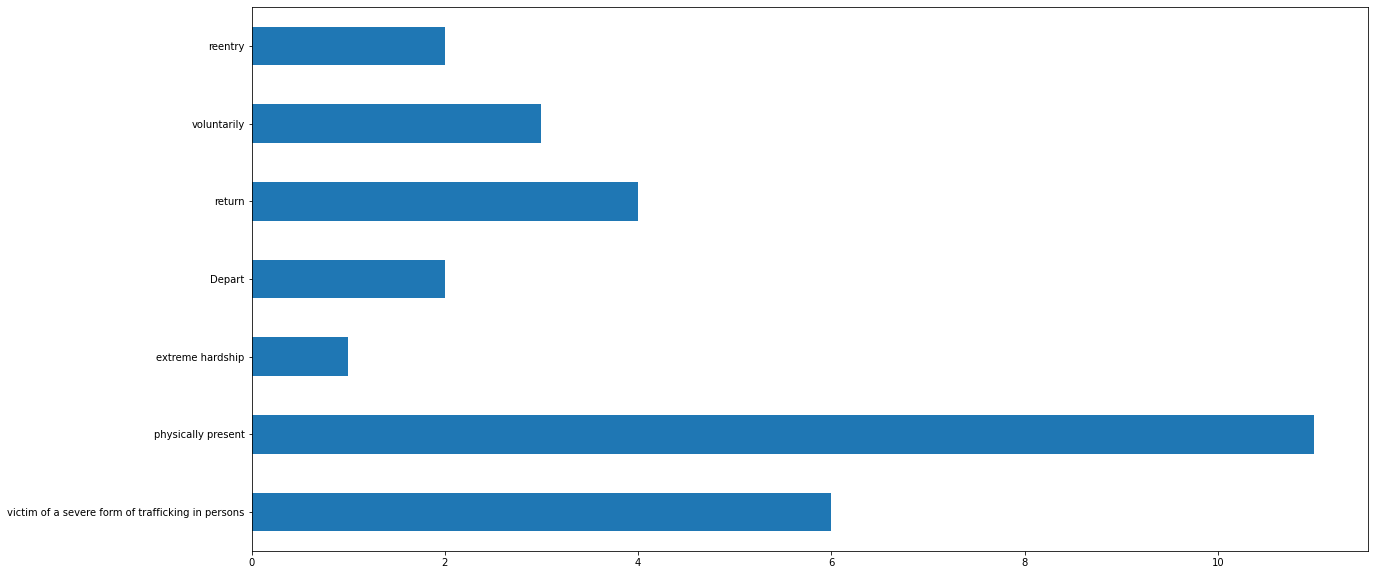

victim of a severe form of trafficking in persons                                                                                                                                                                  6
physically present                                                                                                                                                                                                11
complied with reasonable requests for assistance                                                                                                                                                                   0
extreme hardship                                                                                                                                                                                                   1
inadmissible                                                                                                                                        

In [36]:

keywords=[
"victim of a severe form of trafficking in persons",
"physically present",
"complied with reasonable requests for assistance",
"extreme hardship",
"inadmissible",
"inadmissibility",
"victim of a severe form of trafficking in persons",
"physically present",
"complied with reasonable requests for assistance",
"extreme hardship",
"Inadmissible",
"Inadmissibility",
"Sufficient evidence",
"Any credible evidence",
"Depart",
"return",
"voluntarily",
"reentry",
"8 C.F.R. § 214.1 l(g)(l)(i)- (v)",
"8 C.F.R. § 214.ll(g)(4)",
"USCIS may consider when applicants escaped their traffickers, what activities they have since undertaken to deal with the consequences of having been trafficked, and their ability to leave the United States",
"8 C.F.R. § 214.11 (g)(2)",
"Preponderance",
"Domestic violence",
"Smuggling",
"Escaped a severe form of trafficking in persons before an LEA was involved",
"[e]scaped a severe form of trafficking in persons before an LEA was involved",
"labor exploitation”",
"The Applicant’s Trafficking Claim",
"The Applicant is Not Physically Present On Account of Trafficking",
"Extreme Hardship",
"Reasonable Response",
"Inadmissibility",
]

denied_case_txt_dic={}
for fname in os.listdir('denied'):
    appeal_flag=df[df.file_name==fname]['appealOrMotion'].values[0]=='appeal'
    if appeal_flag:
        denied_case_txt_dic[fname]=PDF_PAGES[fname]


denied_case_txt_all=''
for txt_li,url in denied_case_txt_dic.values():
    for t in txt_li:
        denied_case_txt_all+=t

keywords_cnts={}
for w in keywords:
    keywords_cnts[w]=denied_case_txt_all.count(w)

ser_keywords=pd.Series(keywords_cnts)
ser_keywords[ser_keywords>0].plot(kind='barh',figsize=(20,10))
plt.show()

ser_keywords

In [37]:
ser_keywords[ser_keywords>0]

victim of a severe form of trafficking in persons     6
physically present                                   11
extreme hardship                                      1
Depart                                                2
return                                                4
voluntarily                                           3
reentry                                               2
dtype: int64